# Imports

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import inv_boxcox
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# TDD + LF + XGB

Transformation, Detrending, and Deseasonalizing + Lags and Fourier Terms + XGBoost

In [2]:
class TimeSeriesForecaster:
    def __init__(
        self,
        transform='boxcox',     # 'boxcox' or 'log'
        trend_method='linear',  # 'linear' or 'loess'
        seasonal_period=12,
        lags=[1, 2, 3, 12],
        fourier_order=2,
        xgb_params=None,
        boxcox_shift=None  # If provided, a constant to add to the data; if None, the code auto-determines a shift if needed
    ):
        """
        Parameters:
        -----------
        transform : str
            Transformation to apply ('boxcox' or 'log').
        trend_method : str
            Trend removal method ('linear' or 'loess').
        seasonal_period : int
            Period for seasonal differencing and Fourier features.
        lags : list
            Lag values to include as features.
        fourier_order : int
            Number of sine/cosine pairs to add.
        xgb_params : dict or None
            Parameters for the XGBoost model.
        boxcox_shift : float or None
            A constant to add to the data (if needed for positivity).
        """
        self.transform = transform
        self.trend_method = trend_method
        self.seasonal_period = seasonal_period
        self.lags = lags
        self.fourier_order = fourier_order
        self.boxcox_shift = boxcox_shift
        self.xgb_params = xgb_params if xgb_params is not None else {}
        self.xgb_model = XGBRegressor(**self.xgb_params)

        # Transformation and trend parameters
        self.lambda_ = None             # For Box–Cox
        self.trend_coef = None          # For linear trend
        self.trend_intercept = None     # For linear trend

        # For loess trend, we store the full fitted trend and corresponding x values for extrapolation
        self.loess_trend = None
        self.x_train = None

        # To store series-related info for forecast inversion
        self.seasonal_baseline = None
        self.last_diff = None           # Differenced series from training (after seasonal differencing)
        self.last_detrended = None      # Detrended series from training
        self.last_transformed = None    # Transformed training series
        self.original_train_index = None
        self.train_end_index = None
        self.fitted = False

    def _apply_transformation(self, y):
        """
        Applies the chosen transformation.
        For Box–Cox, checks that data are strictly positive and applies a shift if needed.
        """
        y = y.copy()
        if self.transform == 'boxcox':
            # Determine shift automatically if not provided
            if self.boxcox_shift is None:
                if (y <= 0).any():
                    shift = abs(y.min()) + 1e-6
                else:
                    shift = 0.0
                self.boxcox_shift = shift
            y_shifted = y + self.boxcox_shift
            transformed, self.lambda_ = stats.boxcox(y_shifted)
            return pd.Series(transformed, index=y.index)
        elif self.transform == 'log':
            if self.boxcox_shift is None:
                if (y <= 0).any():
                    shift = abs(y.min()) + 1e-6
                else:
                    shift = 0.0
                self.boxcox_shift = shift
            y_shifted = y + self.boxcox_shift
            transformed = np.log(y_shifted)
            return pd.Series(transformed, index=y.index)
        else:
            return y.copy()

    def _inverse_transformation(self, y_transformed):
        """
        Inverts the transformation using stored parameters.
        """
        if self.transform == 'boxcox':
            inverted = inv_boxcox(y_transformed, self.lambda_)
            return inverted - self.boxcox_shift
        elif self.transform == 'log':
            return np.exp(y_transformed) - self.boxcox_shift
        else:
            return y_transformed

    def _remove_trend(self, y, x=None):
        """
        Removes trend from the series using linear regression or loess.
        If using loess, stores the full trend and x-values for later extrapolation.
        """
        if x is None:
            x = np.arange(len(y)).reshape(-1, 1)
        if self.trend_method == 'linear':
            lr = LinearRegression()
            lr.fit(x, y)
            trend = lr.predict(x)
            self.trend_coef = lr.coef_[0]
            self.trend_intercept = lr.intercept_
        elif self.trend_method == 'loess':
            trend = lowess(endog=y, exog=x.flatten(), frac=0.3, return_sorted=False)
            self.loess_trend = trend
            self.x_train = x.flatten()
        else:
            trend = np.zeros(len(y))
        return y - trend

    def _seasonal_difference(self, y):
        """
        Applies seasonal differencing.
        """
        return y.diff(self.seasonal_period).dropna()

    def _create_lag_features(self, y, lags):
        """
        Creates lag features.
        """
        df = pd.DataFrame({'y': y})
        for lag in lags:
            df[f'lag_{lag}'] = df['y'].shift(lag)
        return df.dropna()

    def _create_fourier_features(self, index, period, order):
        """
        Creates Fourier features (sine and cosine terms) based on the index.
        """
        t = np.arange(len(index))
        features = pd.DataFrame(index=index)
        for k in range(1, order + 1):
            features[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
            features[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
        return features

    def _prepare_features(self, y_series):
        """
        Prepares the feature matrix by combining lag and Fourier features.
        """
        df_lags = self._create_lag_features(y_series, self.lags)
        fourier = self._create_fourier_features(df_lags.index, self.seasonal_period, self.fourier_order)
        X = pd.concat([df_lags.drop(columns='y'), fourier], axis=1)
        y = df_lags['y']
        return X, y

    def fit(self, y):
        """
        Fit the forecasting model on a training time series.
        Stores the transformation, detrending, seasonal baseline, and differenced series for forecasting.
        """
        self.original_train_index = y.index

        # 1. Transform the series
        self.last_transformed = self._apply_transformation(y)

        # 2. Remove trend and store the detrended series
        x_numeric = np.arange(len(self.last_transformed)).reshape(-1, 1)
        self.last_detrended = self._remove_trend(self.last_transformed, x_numeric)

        # 3. Apply seasonal differencing
        y_diff = self._seasonal_difference(self.last_detrended)
        self.last_diff = y_diff.copy()

        # 4. Store seasonal baseline from the last seasonal_period values of the detrended series
        self.seasonal_baseline = list(self.last_detrended[-self.seasonal_period:].values)

        # 5. Prepare features from the differenced series and fit the XGBoost model
        X_train, y_train = self._prepare_features(y_diff)
        self.xgb_model.fit(X_train, y_train)
        self.fitted = True
        self.train_end_index = y.index[-1]

    def _extrapolate_trend(self, steps):
        """
        Extrapolate the trend for future steps using stored trend parameters.
        For a linear trend, uses the stored intercept and coefficient.
        For a loess trend, fits a linear regression on the last few points of the stored loess trend.
        """
        if self.trend_method == 'linear':
            forecast_time = np.arange(len(self.last_transformed), len(self.last_transformed) + steps)
            trend_forecast = self.trend_intercept + self.trend_coef * forecast_time
        elif self.trend_method == 'loess':
            n = len(self.loess_trend)
            k = min(12, n)  # Use up to the last 12 points for extrapolation
            x_subset = self.x_train[-k:].reshape(-1, 1)
            y_subset = self.loess_trend[-k:]
            lr = LinearRegression()
            lr.fit(x_subset, y_subset)
            forecast_time = np.arange(len(self.last_transformed), len(self.last_transformed) + steps).reshape(-1, 1)
            trend_forecast = lr.predict(forecast_time)
        else:
            trend_forecast = np.zeros(steps)
        return trend_forecast

    def predict(self, steps=12, seasonal_baseline=None):
        """
        Forecast future steps using the stored parameters from training.
        This method uses the transformation, trend, and seasonal parameters learned during fit.

        Parameters:
        -----------
        steps : int
            Number of periods to forecast.
        seasonal_baseline : array-like or None
            Optional baseline for seasonal inversion. If None, the stored baseline is used.

        Returns:
        --------
        final_forecast : pandas Series of forecasts on the original data scale.
        """
        if not self.fitted:
            raise Exception("Model must be fitted before forecasting.")

        # Create forecast index starting one period after the training end
        forecast_index = pd.date_range(
            start=self.train_end_index + pd.DateOffset(months=1),
            periods=steps,
            freq='MS'
        )

        # 1. Iterative forecasting in the differenced domain using stored last_diff
        preds_diff = []
        last_diff = self.last_diff.copy()
        for i in range(steps):
            X_temp, _ = self._prepare_features(last_diff)

            # Use the most recent observation (row) as features
            last_features = X_temp.iloc[[-1]]
            pred = self.xgb_model.predict(last_features)[0]
            preds_diff.append(pred)

            # Append the new forecasted difference to extend the series
            new_index = last_diff.index[-1] + pd.DateOffset(months=1)
            new_row = pd.Series(pred, index=[new_index])
            last_diff = pd.concat([last_diff, new_row])
        preds_diff_series = pd.Series(preds_diff, index=forecast_index)

        # 2. Invert seasonal differencing using the stored baseline
        baseline = self.seasonal_baseline.copy() if seasonal_baseline is None else list(seasonal_baseline)
        reconstructed = []
        for i, diff_val in enumerate(preds_diff_series):
            seasonal_val = baseline[i % self.seasonal_period]
            forecast_detrended = diff_val + seasonal_val
            reconstructed.append(forecast_detrended)

            # Update baseline for forecasts beyond the first cycle
            if i >= self.seasonal_period:
                baseline[i % self.seasonal_period] = forecast_detrended
        reconstructed_series = pd.Series(reconstructed, index=forecast_index)

        # 3. Invert trend removal by extrapolating the trend
        trend_forecast = self._extrapolate_trend(steps)
        detrended_forecast = reconstructed_series + trend_forecast

        # 4. Invert the transformation to obtain forecasts on the original scale
        final_forecast = self._inverse_transformation(detrended_forecast)
        return final_forecast

# Data Loading

In [3]:
# Load the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
series = df['Passengers']

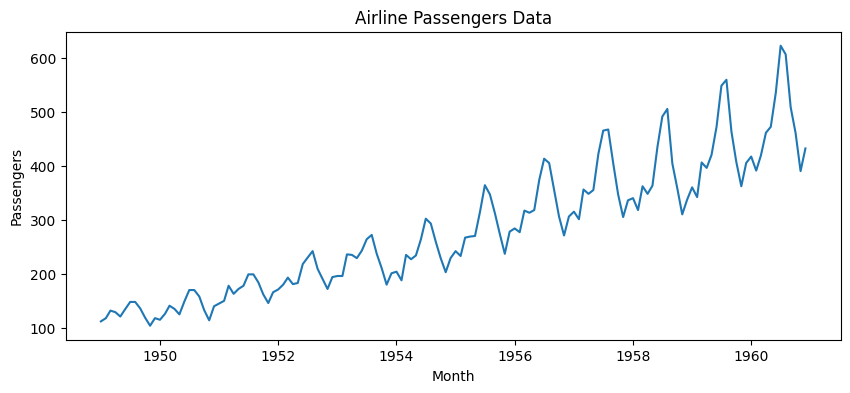

In [4]:
# Plot the data
plt.figure(figsize=(10, 4))
plt.plot(series)
plt.title('Airline Passengers Data')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.show()

# Data Preparation

In [5]:
# Split into training and test sets (last 24 months as test)
test_size = 24
train = series.iloc[:-test_size]
test = series.iloc[-test_size:]
print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 120, Test size: 24


# Model Fitting

In [6]:
# Fit the model
forecaster = TimeSeriesForecaster(
    transform='boxcox',
    trend_method='linear',
    seasonal_period=12,
    lags=[1, 2, 3, 12],
    fourier_order=4,
    xgb_params={
        'n_estimators': 200,
        'max_depth': 20,
        'learning_rate': 0.1,
        'objective': 'reg:squarederror'
    }
)
forecaster.fit(train)

# Model Forecasting

In [7]:
# Forecast the next 24 months
forecast_horizon = 24
forecast_values = forecaster.predict(steps=forecast_horizon)

# Metrics Evaluation

In [8]:
# Evaluate forecast performance
mse = ((forecast_values - test) ** 2).mean()
rmse = np.sqrt(mse)
mae = np.abs(forecast_values - test).mean()
mape = np.mean(np.abs((test - forecast_values) / test)) * 100
smape = np.mean(2 * np.abs(forecast_values - test) / (np.abs(forecast_values) + np.abs(test))) * 100

# Create metrics DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'MAPE', 'SMAPE'],
    'Value': [mse, rmse, mae, mape, smape]
})
display(metrics_df)

,Metric,Value
0,MSE,1172.274151
1,RMSE,34.238489
2,MAE,30.121024
3,MAPE,6.745961
4,SMAPE,6.867621


# Forecast Plotting

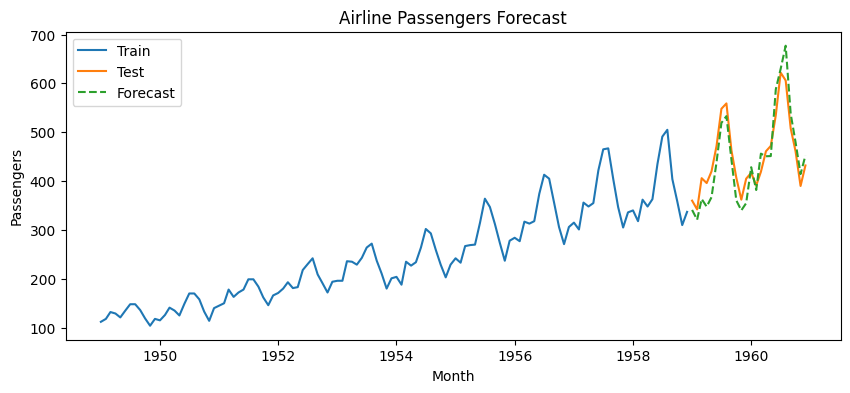

In [9]:
# Plot the forecasts versus the test data
plt.figure(figsize=(10, 4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast_values.index, forecast_values, label='Forecast', linestyle='--')
plt.title("Airline Passengers Forecast")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.legend()
plt.show()